In [15]:
import pandas as pd
import urllib
import io
from bs4 import BeautifulSoup
import numpy as np
from scipy.optimize import linprog
from time import time
import matplotlib.pyplot as plt

In [2]:
# Download and import data

download = False # If download is true download and save data, else just read data

if(download):
    ## Data set
    data_url = "drop"
    df = pd.read_csv(data_url)
    df.to_csv("data.csv", index = False)
    
else:
    df = pd.read_csv("data.csv")


In [3]:
df.head()

,Unnamed: 0,doi,date,title,authors,category
0,0,oai:arXiv.org:0704.0002,2007-03-30,Sparsity-certifying Graph Decompositions,Streinu Ileana;Theran Louis,cs
1,1,oai:arXiv.org:0704.0046,2007-04-01,A limit relation for entropy and channel capac...,Csiszar I.;Hiai F.;Petz D.,cs
2,2,oai:arXiv.org:0704.0047,2007-04-01,Intelligent location of simultaneously active ...,Kosel T.;Grabec I.,cs
3,3,oai:arXiv.org:0704.0050,2007-04-01,Intelligent location of simultaneously active ...,Kosel T.;Grabec I.,cs
4,4,oai:arXiv.org:0704.0062,2007-03-31,On-line Viterbi Algorithm and Its Relationship...,Šrámek Rastislav;Brejová Broňa;Vinař Tomáš,cs


In [4]:
# Cleaning the dataframe
df.dropna(inplace = True)
df.drop("Unnamed: 0", axis = 1, inplace = True) # Drop the "Unnamed: 0" | this was from index

# Get the category list
all_cat = list(set(df["category"].values))
all_cat.sort()

df.head()

,doi,date,title,authors,category
0,oai:arXiv.org:0704.0002,2007-03-30,Sparsity-certifying Graph Decompositions,Streinu Ileana;Theran Louis,cs
1,oai:arXiv.org:0704.0046,2007-04-01,A limit relation for entropy and channel capac...,Csiszar I.;Hiai F.;Petz D.,cs
2,oai:arXiv.org:0704.0047,2007-04-01,Intelligent location of simultaneously active ...,Kosel T.;Grabec I.,cs
3,oai:arXiv.org:0704.0050,2007-04-01,Intelligent location of simultaneously active ...,Kosel T.;Grabec I.,cs
4,oai:arXiv.org:0704.0062,2007-03-31,On-line Viterbi Algorithm and Its Relationship...,Šrámek Rastislav;Brejová Broňa;Vinař Tomáš,cs


In [5]:
# Collecting all the aurhors
au_lst = []
for paper_authors in df["authors"].values:
    for author in paper_authors.split(";"):
        au_lst.append(author)
        
# Get all the unique authors       
au_lst = list(set(au_lst))
au_lst.sort()

au_dict = {author:index for (index, author) in enumerate(au_lst)}
cat_dict = {cat:index for (index, cat) in enumerate(all_cat)}

# Creating the matrix
n = len(au_dict)
p = len(all_cat)
credit_matrix = np.zeros((n, p))

In [6]:
for index, row in df[["authors", "category"]].iterrows():
    
    author_list = row["authors"].split(";")
    contribute = 1.0/len(author_list)
    
    for author in author_list:
        try:
            credit_matrix[ au_dict[author], cat_dict[row["category"]] ] += contribute
        except KeyError as e:
            print(e)

# Calculating stuff
author_activity = credit_matrix / credit_matrix.sum(axis=1, keepdims=True)
author_weight_in_field = credit_matrix / credit_matrix.sum(axis=0, keepdims=True)
field_field_influence = np.transpose(author_activity).dot(author_weight_in_field)

proj1_df = pd.DataFrame(field_field_influence, columns = all_cat, index=all_cat)
proj1_df

,cs,econ,eess,math,physics:astro-ph,physics:cond-mat,physics:gr-qc,physics:hep-ex,physics:hep-lat,physics:hep-ph,physics:hep-th,physics:math-ph,physics:nlin,physics:nucl-ex,physics:nucl-th,physics:physics,physics:quant-ph,q-bio,q-fin,stat
cs,0.651584,0.047335,0.317491,0.045869,3.694852e-03,0.009858,0.002849,0.004423,0.003480,0.002469,0.002271,0.007294,0.030836,0.003093,0.002507,0.037569,0.022480,0.074944,0.047476,0.172155
econ,0.000042,0.326868,0.000082,0.000051,3.298223e-07,0.000001,0.000000,0.000000,0.000000,0.000002,0.000007,0.000001,0.000010,0.000000,0.000000,0.000009,0.000002,0.000005,0.000232,0.001217
eess,0.000894,0.000261,0.331593,0.000116,9.872953e-06,0.000042,0.000004,0.000008,0.000003,0.000004,0.000006,0.000016,0.000117,0.000020,0.000009,0.000162,0.000044,0.000163,0.000132,0.000592
math,0.214964,0.267393,0.193150,0.819245,1.035820e-02,0.040253,0.068572,0.008606,0.022474,0.014461,0.113780,0.525138,0.217989,0.008413,0.014755,0.059113,0.094873,0.108034,0.258144,0.311399
physics:astro-ph,0.005693,0.000572,0.005401,0.003405,8.081777e-01,0.009184,0.150877,0.043321,0.010253,0.073495,0.051997,0.008625,0.017397,0.040450,0.045354,0.049865,0.009356,0.007489,0.004893,0.008808
physics:cond-mat,0.015854,0.002056,0.023857,0.013813,9.585326e-03,0.729312,0.017826,0.009374,0.061746,0.016154,0.044935,0.051607,0.132771,0.019293,0.037222,0.141759,0.145637,0.151131,0.082522,0.012832
physics:gr-qc,0.001314,0.000000,0.000602,0.006746,4.515005e-02,0.005111,0.414458,0.004839,0.011270,0.028019,0.114107,0.029430,0.008280,0.002684,0.006800,0.016139,0.023428,0.002872,0.003021,0.001287
physics:hep-ex,0.001032,0.000000,0.000696,0.000429,6.562819e-03,0.001361,0.002449,0.515324,0.015410,0.063582,0.004482,0.000735,0.000680,0.099703,0.024400,0.018221,0.001522,0.000640,0.000926,0.001130
physics:hep-lat,0.000489,0.000000,0.000166,0.000674,9.354682e-04,0.005398,0.003436,0.009281,0.468093,0.031251,0.019784,0.003113,0.001545,0.009741,0.029398,0.001814,0.002572,0.001559,0.001616,0.000320
physics:hep-ph,0.002189,0.001771,0.001269,0.002737,4.230207e-02,0.008908,0.053892,0.241573,0.197140,0.567605,0.099460,0.010275,0.005437,0.120805,0.217301,0.017384,0.013422,0.003594,0.005090,0.002170


In [7]:
def update_author_funding(credit, field_funding):
    author_weight_in_field = credit / credit.sum(axis=0,keepdims=True)
    author_funding_from_field = author_weight_in_field * field_funding
    author_funding = author_funding_from_field.sum(axis=1,keepdims=True)
    return author_funding

def compute_credit(author_funding):
    new_credit = author_prod * author_funding
    field_credit = new_credit.sum(axis=0)
    author_credit = new_credit.sum(axis=1)
    total_credit = new_credit.sum()
    return new_credit, total_credit

In [26]:
num_field = len(all_cat)
num_auth  = len(au_lst)
num_steps = 500

# Learning hyperparameter
p = 0.05
alpha = 0.08

# Current credit
current_credit = credit_matrix

# Current field funding - Generating a random funding
d = np.random.rand(num_field)
current_field_funding = d / d.sum()

# Saving the original field funding 
original_field_funding = current_field_funding.copy()

In [27]:
# Initial calculation
current_author_funding = update_author_funding(current_credit, current_field_funding)
author_prod = current_credit / current_author_funding # This is invariance
current_credit, current_total_credit = compute_credit(current_author_funding)

# Initialize the best state
best_field_funding = current_field_funding.copy()
best_credit        = current_credit.copy()
best_total_credit  = current_total_credit.copy()

tot_credit_lst = []

In [28]:
for i in range(num_steps):
    current_author_weight_in_field = current_credit / current_credit.sum(axis=0,keepdims=True)

    if(np.random.rand() < 0.05):
        gradient = np.random.rand(num_field)
    else:
        gradient = (author_prod * current_author_weight_in_field).sum(axis = 0)

    gradient_norm = gradient/(sum(gradient))  # normalize
    # Update field funding
    new_field_funding = current_field_funding + alpha*gradient_norm
    new_field_funding = new_field_funding / (sum(new_field_funding)) # normalize 

    new_author_funding = update_author_funding(current_credit, new_field_funding)
    new_credit, new_total_credit = compute_credit(new_author_funding)
    
    tot_credit_lst.append(new_total_credit)
    
    # update the new best result
    if(best_total_credit < new_total_credit):
        best_field_funding = new_field_funding.copy()
        best_credit        = new_credit.copy()
        best_total_credit  = new_total_credit.copy()

#         print("new Best")

    # Update for new step 
    current_field_funding = new_field_funding.copy()
    current_credit        = new_credit.copy()

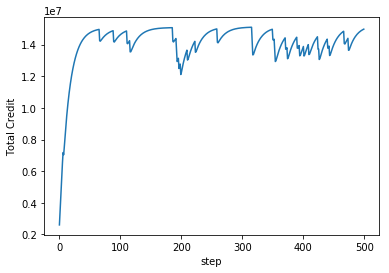

In [29]:
plt.plot(tot_credit_lst)
plt.ylabel('Total Credit')
plt.xlabel('step')
plt.show()

In [32]:
pd.DataFrame(best_field_funding, columns = ["Field Funding"], index = all_cat)

,Field Funding
cs,0.025640
econ,0.000085
eess,0.000180
math,0.409131
physics:astro-ph,0.261749
physics:cond-mat,0.130408
physics:gr-qc,0.012766
physics:hep-ex,0.005109
physics:hep-lat,0.023656
physics:hep-ph,0.015799
